# Daniels parts analysis

In [36]:
import  pandas
import re
import pygal
from IPython.display import SVG, display

In [37]:
# Note: data downloaded 17/March/2024
data = pandas.read_excel("./source/Amplifier SINAD list ASR + 3rd parties.xlsx", 
                  engine="openpyxl",
                  sheet_name="data")

In [38]:
data.columns

Index(['Name', 'SINAD (dB)\n(5W, 4 ohms)', 'Price (USD)', 'Less than 150W',
       'Between 150 and 300 W', 'Between 300 and 450W', 'Between 450 and 600W',
       'More than 600W', 'Power (W)\n(1% THD+N, 4 ohms)'],
      dtype='object')

In [39]:
#  rename columns

data = data[
    [
        "Name", "SINAD (dB)\n(5W, 4 ohms)", "Price (USD)", "Power (W)\n(1% THD+N, 4 ohms)"
    ]
]
data.columns = [
    "name",  "sinad_5w_4ohm", "price_usd", "thd_1pc_4ohm"
]

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           624 non-null    object 
 1   sinad_5w_4ohm  624 non-null    float64
 2   price_usd      622 non-null    object 
 3   thd_1pc_4ohm   624 non-null    float64
dtypes: float64(2), object(2)
memory usage: 19.6+ KB


In [41]:
describe = data.describe()
describe

,sinad_5w_4ohm,thd_1pc_4ohm
count,624.000000,624.000000
mean,77.212275,325.145962
std,16.290715,327.986236
min,22.974833,0.180000
25%,66.196078,115.000000
50%,76.478175,230.000000
75%,87.958800,421.250000
max,120.630341,2500.000000


In [42]:
###  can use these quartiles to divide thd column  into 4 categories

first_quartile_thd_bound = describe.loc["25%", "thd_1pc_4ohm"]
second_quartile_thd_bound = describe.loc["50%", "thd_1pc_4ohm"]
third_quartile_thd_bound = describe.loc["75%", "thd_1pc_4ohm"]

In [43]:
# an outlier is any number less than or greater than . 
interquartile_range = third_quartile_thd_bound - first_quartile_thd_bound
lower_bound_outlier = first_quartile_thd_bound - (1.5 * interquartile_range)
upper_bound_outlier = third_quartile_thd_bound + (1.5 * interquartile_range)

def is_thd_outlier(thd):
    if thd > upper_bound_outlier or thd < lower_bound_outlier:
        return True
    return False

In [44]:
quartile_dict = {
    "Q1": f"0 - {first_quartile_thd_bound} watts",
    "Q2": f"{first_quartile_thd_bound} watts - {second_quartile_thd_bound} watts",
    "Q3": f"{second_quartile_thd_bound} watts - {third_quartile_thd_bound} watts",
    "Q4": f"{third_quartile_thd_bound} watts and above"
}

def parse_thd_category(thd):
    if (thd < first_quartile_thd_bound):
        return quartile_dict["Q1"]
    elif (thd < second_quartile_thd_bound):
        return quartile_dict["Q2"]
    elif (thd < third_quartile_thd_bound):
        return quartile_dict["Q3"]
    return quartile_dict["Q4"]

def parse_thd_category_as_quartile(thd):
    if (thd < first_quartile_thd_bound):
        return "quartile 1"
    elif (thd < second_quartile_thd_bound):
        return "quartile 2"
    elif (thd < third_quartile_thd_bound):
        return "quartile 3"
    return "quartile 4"

In [45]:
def parse_usd(price):
    parsed = re.match("^\d+",  str(price))
    if (parsed is None):
        return -1
    return float(price)

In [46]:
def display_and_export_ranked_horizontal_bar_chart(chart_data, chart_title, x_axis, y_axis, export_location):
    values = list(zip(chart_data[y_axis], chart_data[x_axis]))
    chart = pygal.HorizontalBar(legend_at_bottom=True,
                                show_legend=False,
                                human_readable=True, 
                                print_values=True,
                               print_labels=True)
    chart.title = chart_title
    
    # order needs to be reversed because pygal inserts data from bottom to top
    chart.x_labels = list(reversed(list(chart_data[y_axis])))
    chart.add("", list(reversed(list(chart_data[x_axis]))))

    chart.render_to_file(export_location)
#     display(SVG(chart.render(disable_xml_declaration=True)))

In [47]:
# convert  the price column to float values and get rid of entries without a price
data["price_usd"] = data["price_usd"].apply(parse_usd)
data = data[data["price_usd"] > 0]

In [48]:
data["thd_category"] = data["thd_1pc_4ohm"].apply(parse_thd_category)
data["thd_quartile"] = data["thd_1pc_4ohm"].apply(parse_thd_category_as_quartile)
data["is_thd_outlier"] = data["thd_1pc_4ohm"].apply(is_thd_outlier)

In [49]:
data["price_to_sinad"] = data.apply(lambda x: x.sinad_5w_4ohm / x.price_usd, axis=1)
data["price_to_thd_1pc"] = data.apply(lambda x: x.thd_1pc_4ohm / x.price_usd, axis=1)

In [50]:
data.shape

(621, 9)

## THD @ 1% 4ohm analysis

### Top 10 price to thd 1% regardless of price

In [51]:
subset = data.sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
182,Pascal X-PRO1,85.679933,700.0,2000.0,421.25 watts and above,quartile 4,True,0.122400,2.857143
572,Rockville RPA16,54.424928,390.0,885.0,421.25 watts and above,quartile 4,True,0.139551,2.269231
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
221,Fosi Audio BT20A Pro (48 V),83.098039,140.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.593557,1.285714
434,Behringer NX3000D,68.635966,390.0,500.0,421.25 watts and above,quartile 4,False,0.175990,1.282051
116,ICEpower 700AS2,91.700533,576.0,720.0,421.25 watts and above,quartile 4,False,0.159202,1.250000
410,Crown XLS 2502,70.752040,650.0,800.0,421.25 watts and above,quartile 4,False,0.108849,1.230769
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667


In [52]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% regardless of price',
    export_location='./chart-exports/top-10-price_to_thd_1pc-unfiltered.svg'
)

<img src="chart-exports/top-10-price_to_thd_1pc-unfiltered.svg" width="1000"/>

### Top 10 price to thd 1%,  under 125USD

In [18]:
subset = data[data["price_usd"] < 125].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
489,UWAYKEY ZK-502H,64.293403,18.0,20.0,0 - 115.0 watts,quartile 1,False,3.571856,1.111111
230,AIYIMA A08 Pro,82.733543,106.0,115.0,115.0 watts - 230.0 watts,quartile 2,False,0.780505,1.084906
369,AIYIMA A05,73.555614,80.0,80.0,0 - 115.0 watts,quartile 1,False,0.919445,1.000000
146,Fosi Audio V3 (32V PS),88.404328,90.0,85.0,0 - 115.0 watts,quartile 1,False,0.982270,0.944444
318,Sabaj A1 (2022),75.917600,70.0,55.0,0 - 115.0 watts,quartile 1,False,1.084537,0.785714
220,Fosi Audio BT20A Pro (32 V),83.223018,100.0,77.0,0 - 115.0 watts,quartile 1,False,0.832230,0.770000


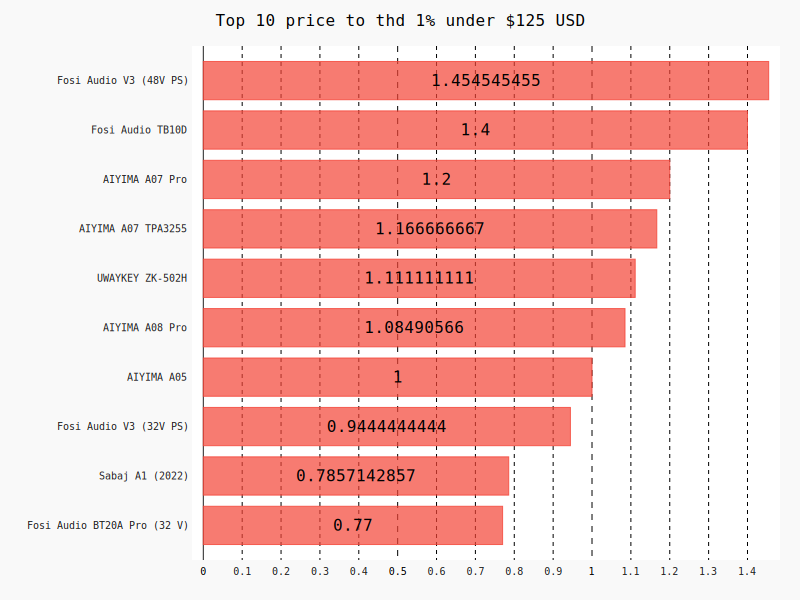

In [19]:

display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% under $125 USD',
    export_location='./chart-exports/top-10-price_to_thd_1pc-under-125-usd.svg'
)

### Top 10 price to thd 1%,  under 250USD

In [20]:
subset = data[data["price_usd"] < 250].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
221,Fosi Audio BT20A Pro (48 V),83.098039,140.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.593557,1.285714
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
489,UWAYKEY ZK-502H,64.293403,18.0,20.0,0 - 115.0 watts,quartile 1,False,3.571856,1.111111
230,AIYIMA A08 Pro,82.733543,106.0,115.0,115.0 watts - 230.0 watts,quartile 2,False,0.780505,1.084906
370,Monoprice Studio 605030,73.555614,152.0,157.0,115.0 watts - 230.0 watts,quartile 2,False,0.483919,1.032895
452,Behringer A500,67.330631,200.0,200.0,115.0 watts - 230.0 watts,quartile 2,False,0.336653,1.000000
369,AIYIMA A05,73.555614,80.0,80.0,0 - 115.0 watts,quartile 1,False,0.919445,1.000000


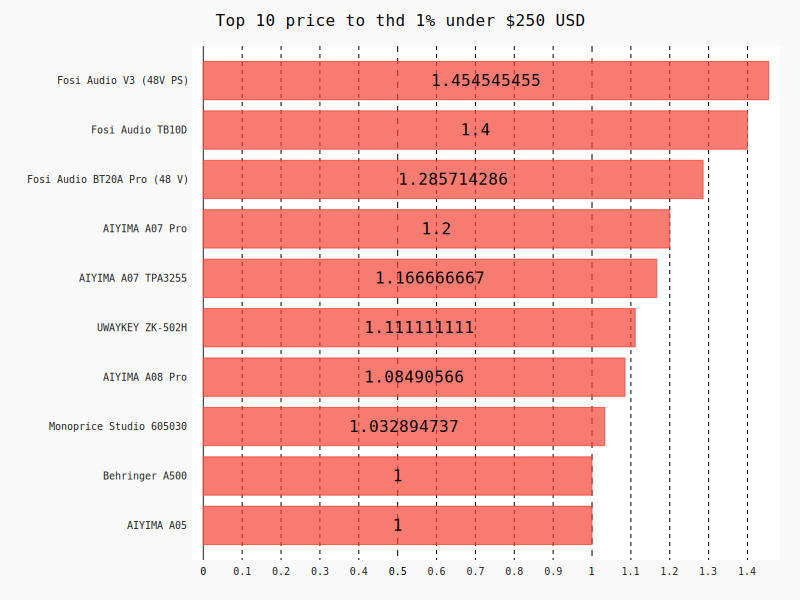

In [21]:

display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% under $250 USD',
    export_location='./chart-exports/top-10-price_to_thd_1pc-under-250-usd.svg'
)

### Top 10 price to thd 1%,  under 500USD

In [22]:
subset = data[data["price_usd"] < 500].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
572,Rockville RPA16,54.424928,390.0,885.0,421.25 watts and above,quartile 4,True,0.139551,2.269231
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
221,Fosi Audio BT20A Pro (48 V),83.098039,140.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.593557,1.285714
434,Behringer NX3000D,68.635966,390.0,500.0,421.25 watts and above,quartile 4,False,0.175990,1.282051
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
558,Crown XLi 800,56.478175,270.0,315.0,230.0 watts - 421.25 watts,quartile 3,False,0.209178,1.166667
489,UWAYKEY ZK-502H,64.293403,18.0,20.0,0 - 115.0 watts,quartile 1,False,3.571856,1.111111
230,AIYIMA A08 Pro,82.733543,106.0,115.0,115.0 watts - 230.0 watts,quartile 2,False,0.780505,1.084906


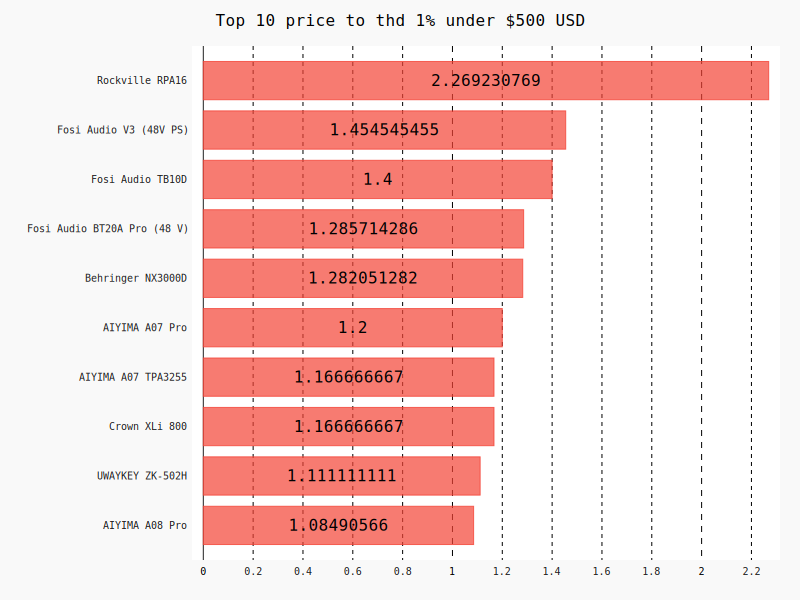

In [23]:

display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% under $500 USD',
    export_location='./chart-exports/top-10-price_to_thd_1pc-under-500-usd.svg'
)

### Top 10 price to thd 1%,  under 1000USD

In [24]:
subset = data[data["price_usd"] < 1000].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
182,Pascal X-PRO1,85.679933,700.0,2000.0,421.25 watts and above,quartile 4,True,0.122400,2.857143
572,Rockville RPA16,54.424928,390.0,885.0,421.25 watts and above,quartile 4,True,0.139551,2.269231
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
221,Fosi Audio BT20A Pro (48 V),83.098039,140.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.593557,1.285714
434,Behringer NX3000D,68.635966,390.0,500.0,421.25 watts and above,quartile 4,False,0.175990,1.282051
116,ICEpower 700AS2,91.700533,576.0,720.0,421.25 watts and above,quartile 4,False,0.159202,1.250000
410,Crown XLS 2502,70.752040,650.0,800.0,421.25 watts and above,quartile 4,False,0.108849,1.230769
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
558,Crown XLi 800,56.478175,270.0,315.0,230.0 watts - 421.25 watts,quartile 3,False,0.209178,1.166667


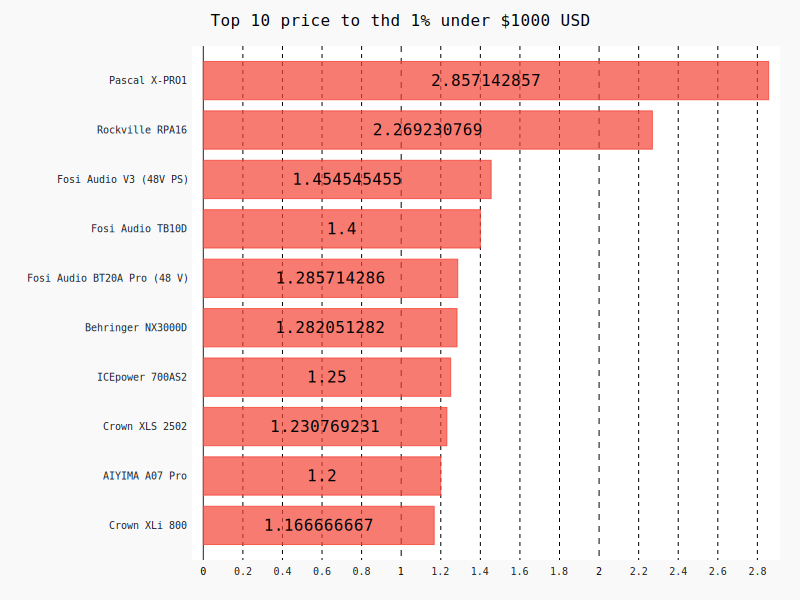

In [25]:

display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% under $1000 USD',
    export_location='./chart-exports/top-10-price_to_thd_1pc-under-1000-usd.svg'
)

### Top 10 price to thd 1%, in first quartile (thd_1pc_4ohm) category

In [26]:
subset = data[
    data["thd_quartile"] == "quartile 1"
].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset 

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
489,UWAYKEY ZK-502H,64.293403,18.0,20.0,0 - 115.0 watts,quartile 1,False,3.571856,1.111111
369,AIYIMA A05,73.555614,80.0,80.0,0 - 115.0 watts,quartile 1,False,0.919445,1.000000
146,Fosi Audio V3 (32V PS),88.404328,90.0,85.0,0 - 115.0 watts,quartile 1,False,0.982270,0.944444
318,Sabaj A1 (2022),75.917600,70.0,55.0,0 - 115.0 watts,quartile 1,False,1.084537,0.785714
220,Fosi Audio BT20A Pro (32 V),83.223018,100.0,77.0,0 - 115.0 watts,quartile 1,False,0.832230,0.770000
285,Douk Audio H7,78.416375,144.0,103.0,0 - 115.0 watts,quartile 1,False,0.544558,0.715278
432,Topping PA3,68.873950,120.0,80.0,0 - 115.0 watts,quartile 1,False,0.573950,0.666667


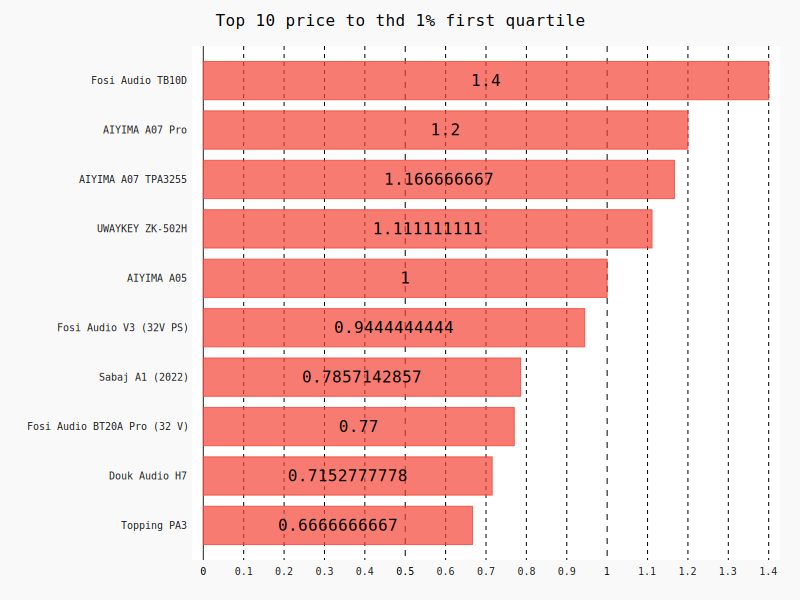

In [27]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% first quartile',
    export_location='./chart-exports/top-10-price-to-thd-1pc-first-quartile.svg'
)

### Top 10 price to thd 1%, in second quartile (thd_1pc_4ohm) category

In [28]:
subset = data[
    data["thd_quartile"] == "quartile 2"
].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
221,Fosi Audio BT20A Pro (48 V),83.098039,140.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.593557,1.285714
230,AIYIMA A08 Pro,82.733543,106.0,115.0,115.0 watts - 230.0 watts,quartile 2,False,0.780505,1.084906
370,Monoprice Studio 605030,73.555614,152.0,157.0,115.0 watts - 230.0 watts,quartile 2,False,0.483919,1.032895
452,Behringer A500,67.330631,200.0,200.0,115.0 watts - 230.0 watts,quartile 2,False,0.336653,1.000000
158,Fosi Audio ZA3 48V PS,87.535014,150.0,147.0,115.0 watts - 230.0 watts,quartile 2,False,0.583567,0.980000
320,Hypex UcD180HG HxR,75.917600,135.0,130.0,115.0 watts - 230.0 watts,quartile 2,False,0.562353,0.962963
444,Pyle PT8000CH 8-Channel,67.958800,270.0,227.0,115.0 watts - 230.0 watts,quartile 2,False,0.251699,0.840741
295,Yamaha R-S202,77.721133,200.0,163.0,115.0 watts - 230.0 watts,quartile 2,False,0.388606,0.815000
79,AIYIMA A70 PS 48V 10A,94.894550,220.0,178.0,115.0 watts - 230.0 watts,quartile 2,False,0.431339,0.809091


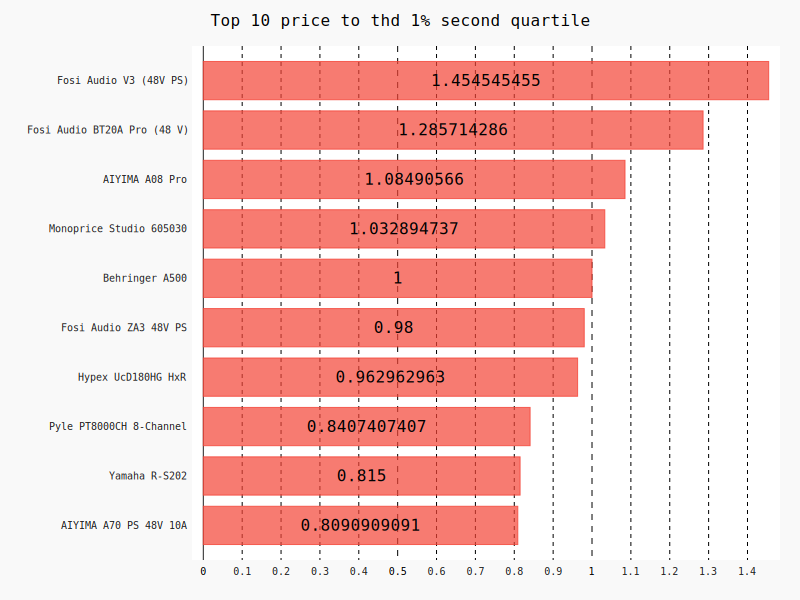

In [29]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% second quartile',
    export_location='./chart-exports/top-10-price-to-thd-1pc-second-quartile.svg'
)

### Top 10 price to thd 1%, in third quartile (thd_1pc_4ohm) category

In [30]:
subset = data[
    data["thd_quartile"] == "quartile 3"
].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
558,Crown XLi 800,56.478175,270.0,315.0,230.0 watts - 421.25 watts,quartile 3,False,0.209178,1.166667
304,Behringer A800,77.077439,300.0,310.0,230.0 watts - 421.25 watts,quartile 3,False,0.256925,1.033333
344,Crown XLS 1002,74.894550,340.0,330.0,230.0 watts - 421.25 watts,quartile 3,False,0.220278,0.970588
121,ICEpower 300AS1,91.056839,435.0,310.0,230.0 watts - 421.25 watts,quartile 3,False,0.209326,0.712644
112,ICEpower 125ASX2 (bridge),92.041200,540.0,370.0,230.0 watts - 421.25 watts,quartile 3,False,0.170447,0.685185
80,NAD 2200 lab in,94.894550,530.0,323.0,230.0 watts - 421.25 watts,quartile 3,False,0.179046,0.609434
107,NAD 2200 normal in,92.765443,530.0,323.0,230.0 watts - 421.25 watts,quartile 3,False,0.175029,0.609434
61,Hypex NCore NC252MP,98.416375,430.0,250.0,230.0 watts - 421.25 watts,quartile 3,False,0.228875,0.581395
411,Dayton Audio APA1200DSP,70.752040,650.0,354.0,230.0 watts - 421.25 watts,quartile 3,False,0.108849,0.544615
77,Audiophonics MPA-S250NC RCA,95.391022,444.0,233.0,230.0 watts - 421.25 watts,quartile 3,False,0.214845,0.524775


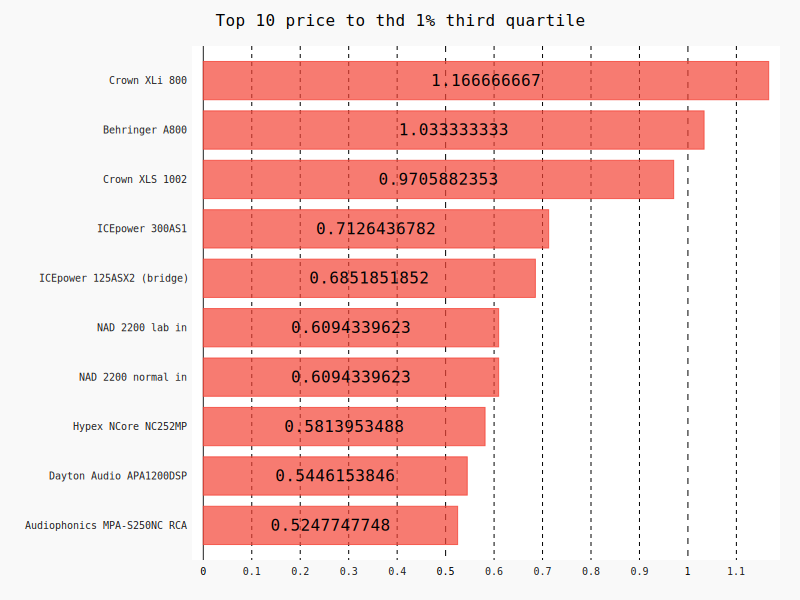

In [31]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% third quartile',
    export_location='./chart-exports/top-10-price-to-thd-1pc-third-quartile.svg'
)

### Top 10 price to thd 1%, in fourth quartile (thd_1pc_4ohm) category

In [32]:
subset = data[
    data["thd_quartile"] == "quartile 4"
].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset 

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
182,Pascal X-PRO1,85.679933,700.0,2000.0,421.25 watts and above,quartile 4,True,0.122400,2.857143
572,Rockville RPA16,54.424928,390.0,885.0,421.25 watts and above,quartile 4,True,0.139551,2.269231
434,Behringer NX3000D,68.635966,390.0,500.0,421.25 watts and above,quartile 4,False,0.175990,1.282051
116,ICEpower 700AS2,91.700533,576.0,720.0,421.25 watts and above,quartile 4,False,0.159202,1.250000
410,Crown XLS 2502,70.752040,650.0,800.0,421.25 watts and above,quartile 4,False,0.108849,1.230769
64,ICEpower 2000AS2 HV,98.416375,898.0,1000.0,421.25 watts and above,quartile 4,True,0.109595,1.113586
19,Hypex NCore NC2K OEM,106.744843,2360.0,2500.0,421.25 watts and above,quartile 4,True,0.045231,1.059322
331,ICEpower 1000ASP,75.391022,1136.0,1175.0,421.25 watts and above,quartile 4,True,0.066365,1.034331
323,Crown XLS 1502,75.917600,500.0,500.0,421.25 watts and above,quartile 4,False,0.151835,1.000000
88,ICEpower 1200AS2,93.979400,745.0,670.0,421.25 watts and above,quartile 4,False,0.126147,0.899329


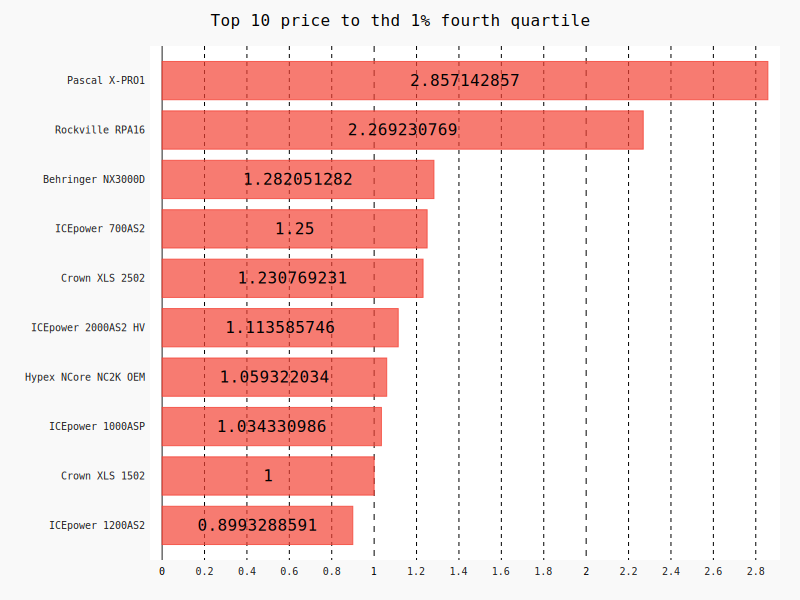

In [33]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1% fourth quartile',
    export_location='./chart-exports/top-10-price-to-thd-1pc-fourth-quartile.svg'
)

### Top 10 price to thd 1%, where sinad is >= 80

In [34]:
subset = data[
    data["sinad_5w_4ohm"] >= 80
].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
182,Pascal X-PRO1,85.679933,700.0,2000.0,421.25 watts and above,quartile 4,True,0.122400,2.857143
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
221,Fosi Audio BT20A Pro (48 V),83.098039,140.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.593557,1.285714
116,ICEpower 700AS2,91.700533,576.0,720.0,421.25 watts and above,quartile 4,False,0.159202,1.250000
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
64,ICEpower 2000AS2 HV,98.416375,898.0,1000.0,421.25 watts and above,quartile 4,True,0.109595,1.113586
230,AIYIMA A08 Pro,82.733543,106.0,115.0,115.0 watts - 230.0 watts,quartile 2,False,0.780505,1.084906
19,Hypex NCore NC2K OEM,106.744843,2360.0,2500.0,421.25 watts and above,quartile 4,True,0.045231,1.059322
158,Fosi Audio ZA3 48V PS,87.535014,150.0,147.0,115.0 watts - 230.0 watts,quartile 2,False,0.583567,0.980000


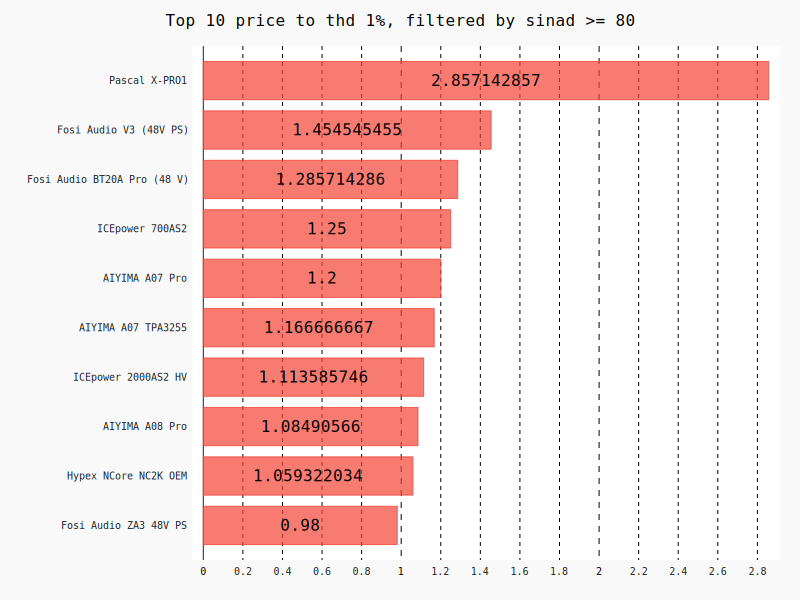

In [35]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1%, filtered by sinad >= 80',
    export_location='./chart-exports/top-10-price-to-thd-1pc-sinad-over-equal-80.svg'
)

### Top 10 price to thd 1%, where sinad is >= 100

In [36]:
subset = data[
    data["sinad_5w_4ohm"] >= 100
].sort_values("price_to_thd_1pc", ascending=False).head(10)
subset

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
19,Hypex NCore NC2K OEM,106.744843,2360.0,2500.0,421.25 watts and above,quartile 4,True,0.045231,1.059322
50,Hypex NCore NC502MP,101.411621,635.0,500.0,421.25 watts and above,quartile 4,False,0.159703,0.787402
22,Hypex NCoreX NCx500 OEM (buffered),106.196078,970.0,656.0,421.25 watts and above,quartile 4,False,0.109480,0.676289
8,Hypex NCoreX NCx500 OEM (bufferless),113.151546,970.0,656.0,421.25 watts and above,quartile 4,False,0.116651,0.676289
12,Apollon NCx500ST (low gain),112.395775,1165.0,644.0,421.25 watts and above,quartile 4,False,0.096477,0.552790
43,3e audio TPA3255 260-2-29A,101.938200,375.0,206.0,115.0 watts - 230.0 watts,quartile 2,False,0.271835,0.549333
28,Topping PA5 II,104.882503,220.0,120.0,115.0 watts - 230.0 watts,quartile 2,False,0.476739,0.545455
38,Hypex NCore NC1200 OEM,103.098039,1390.0,700.0,421.25 watts and above,quartile 4,False,0.074171,0.503597
29,TP RA3,104.582960,269.0,131.0,115.0 watts - 230.0 watts,quartile 2,False,0.388784,0.486989
27,Apollon NCx500ST (highest gain),105.679933,1165.0,536.0,421.25 watts and above,quartile 4,False,0.090712,0.460086


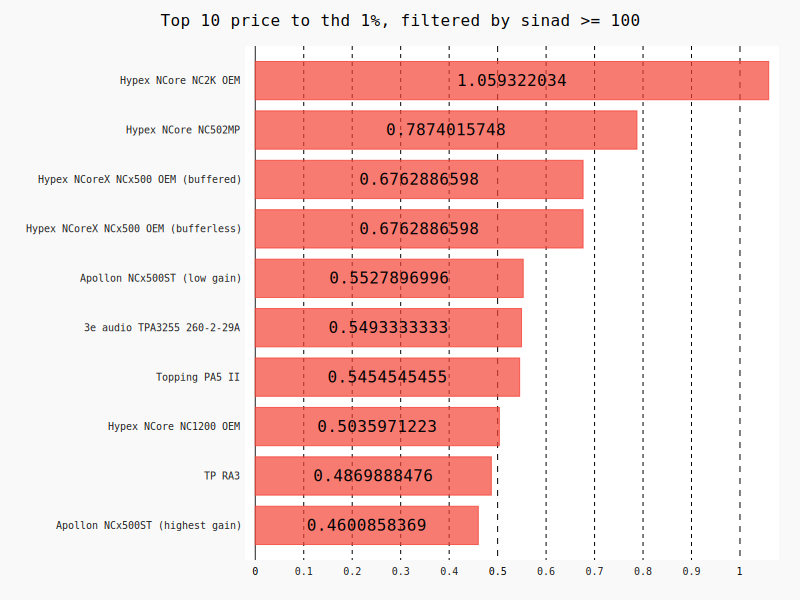

In [37]:
display_and_export_ranked_horizontal_bar_chart(
    chart_data=subset,
    x_axis='price_to_thd_1pc',
    y_axis='name',
    chart_title='Top 10 price to thd 1%, filtered by sinad >= 100',
    export_location='./chart-exports/top-10-price-to-thd-1pc-sinad-over-equal-100.svg'
)

## Sinad analysis

### Top 20 sinad performance overall

In [38]:
data.sort_values("sinad_5w_4ohm", ascending=False).head(20)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
0,"Topping LA90 (stereo, bypass, low gain)",120.630341,800.0,90.0,0 - 115.0 watts,quartile 1,False,0.150788,0.112500
1,"Topping LA90 Discrete (bridged, low gain)",119.659333,1600.0,320.0,230.0 watts - 421.25 watts,quartile 3,False,0.074787,0.200000
2,"Topping LA90 Discrete (stereo, low gain)",119.576214,800.0,91.0,0 - 115.0 watts,quartile 1,False,0.149470,0.113750
3,"Topping LA90 (bridged, bypass, low gain)",119.172146,1600.0,180.0,115.0 watts - 230.0 watts,quartile 2,False,0.074483,0.112500
4,"Topping LA90 Discrete (stereo, high gain)",116.923703,800.0,91.0,0 - 115.0 watts,quartile 1,False,0.146155,0.113750
5,"Topping LA90 (stereo, bypass, high gain)",116.832750,800.0,90.0,0 - 115.0 watts,quartile 1,False,0.146041,0.112500
7,"Topping LA90 (stereo, volume, low gain)",115.239078,800.0,90.0,0 - 115.0 watts,quartile 1,False,0.144049,0.112500
8,Hypex NCoreX NCx500 OEM (bufferless),113.151546,970.0,656.0,421.25 watts and above,quartile 4,False,0.116651,0.676289
10,Hypex Nilai500DIY mono kit (low gain),112.765443,1800.0,501.0,421.25 watts and above,quartile 4,False,0.062647,0.278333
11,"Benchmark AHB2 (stereo, low gain)",112.765443,3000.0,210.0,115.0 watts - 230.0 watts,quartile 2,False,0.037588,0.070000


### Top 20 sinad per dollar performance, overall

In [39]:
data.sort_values("price_to_sinad", ascending=False).head(20)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
489,UWAYKEY ZK-502H,64.293403,18.0,20.0,0 - 115.0 watts,quartile 1,False,3.571856,1.111111
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
441,Sabaj A1 (2020),68.178708,60.0,22.0,0 - 115.0 watts,quartile 1,False,1.136312,0.366667
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
318,Sabaj A1 (2022),75.917600,70.0,55.0,0 - 115.0 watts,quartile 1,False,1.084537,0.785714
476,Fosi Audio BT10A,64.882503,60.0,35.0,0 - 115.0 watts,quartile 1,False,1.081375,0.583333
146,Fosi Audio V3 (32V PS),88.404328,90.0,85.0,0 - 115.0 watts,quartile 1,False,0.982270,0.944444
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
369,AIYIMA A05,73.555614,80.0,80.0,0 - 115.0 watts,quartile 1,False,0.919445,1.000000
220,Fosi Audio BT20A Pro (32 V),83.223018,100.0,77.0,0 - 115.0 watts,quartile 1,False,0.832230,0.770000


### Top 10 sinad per dollar performance, where sinad is > 80

In [40]:
data[data["sinad_5w_4ohm"]  >= 80].sort_values("price_to_sinad", ascending=False).head(10)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
146,Fosi Audio V3 (32V PS),88.404328,90.0,85.0,0 - 115.0 watts,quartile 1,False,0.982270,0.944444
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000
220,Fosi Audio BT20A Pro (32 V),83.223018,100.0,77.0,0 - 115.0 watts,quartile 1,False,0.832230,0.770000
249,SMSL DA-6,81.310031,100.0,39.0,0 - 115.0 watts,quartile 1,False,0.813100,0.390000
147,Fosi Audio V3 (48V PS),88.404328,110.0,160.0,115.0 watts - 230.0 watts,quartile 2,False,0.803676,1.454545
230,AIYIMA A08 Pro,82.733543,106.0,115.0,115.0 watts - 230.0 watts,quartile 2,False,0.780505,1.084906
270,3e Audio SY-DAP2002 (LM4562 upgrade),80.000000,116.0,75.0,0 - 115.0 watts,quartile 1,False,0.689655,0.646552
214,Allo Volt+ D,83.609121,129.0,62.0,0 - 115.0 watts,quartile 1,False,0.648133,0.480620
120,ICEpower 50ASX2 (stereo),91.056839,147.0,50.0,0 - 115.0 watts,quartile 1,False,0.619434,0.340136


### Top 10 sinad per dollar performance, where sinad is > 90

In [41]:
data[data["sinad_5w_4ohm"]  >= 90].sort_values("price_to_sinad", ascending=False).head(10)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
120,ICEpower 50ASX2 (stereo),91.056839,147.0,50.0,0 - 115.0 watts,quartile 1,False,0.619434,0.340136
115,Topping PA3s,91.700533,150.0,65.0,0 - 115.0 watts,quartile 1,False,0.611337,0.433333
126,Loxjie A30,90.457575,150.0,80.0,0 - 115.0 watts,quartile 1,False,0.603050,0.533333
28,Topping PA5 II,104.882503,220.0,120.0,115.0 watts - 230.0 watts,quartile 2,False,0.476739,0.545455
98,Topping MX3s,93.151546,200.0,58.0,0 - 115.0 watts,quartile 1,False,0.465758,0.290000
79,AIYIMA A70 PS 48V 10A,94.894550,220.0,178.0,115.0 watts - 230.0 watts,quartile 2,False,0.431339,0.809091
86,ICEpower 125ASX2 (stereo),93.979400,240.0,105.0,0 - 115.0 watts,quartile 1,False,0.391581,0.437500
29,TP RA3,104.582960,269.0,131.0,115.0 watts - 230.0 watts,quartile 2,False,0.388784,0.486989
78,Topping MX5,95.391022,300.0,55.0,0 - 115.0 watts,quartile 1,False,0.317970,0.183333
23,Topping PA5,106.231604,350.0,131.0,115.0 watts - 230.0 watts,quartile 2,False,0.303519,0.374286


### Top 10 sinad per dollar performance, where sinad is > 100

In [42]:
data[data["sinad_5w_4ohm"]  >= 100].sort_values("price_to_sinad", ascending=False).head(10)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
28,Topping PA5 II,104.882503,220.0,120.0,115.0 watts - 230.0 watts,quartile 2,False,0.476739,0.545455
29,TP RA3,104.582960,269.0,131.0,115.0 watts - 230.0 watts,quartile 2,False,0.388784,0.486989
23,Topping PA5,106.231604,350.0,131.0,115.0 watts - 230.0 watts,quartile 2,False,0.303519,0.374286
49,Hypex NCore NC52MP,101.411621,345.0,50.0,0 - 115.0 watts,quartile 1,False,0.293947,0.144928
43,3e audio TPA3255 260-2-29A,101.938200,375.0,206.0,115.0 watts - 230.0 watts,quartile 2,False,0.271835,0.549333
44,Topping PA7 Plus,101.938200,550.0,240.0,230.0 watts - 421.25 watts,quartile 3,False,0.185342,0.436364
56,March Audio P122,100.000000,595.0,126.0,115.0 watts - 230.0 watts,quartile 2,False,0.168067,0.211765
50,Hypex NCore NC502MP,101.411621,635.0,500.0,421.25 watts and above,quartile 4,False,0.159703,0.787402
0,"Topping LA90 (stereo, bypass, low gain)",120.630341,800.0,90.0,0 - 115.0 watts,quartile 1,False,0.150788,0.112500
2,"Topping LA90 Discrete (stereo, low gain)",119.576214,800.0,91.0,0 - 115.0 watts,quartile 1,False,0.149470,0.113750


## Price analysis

### Most expensive 20

In [43]:
data.sort_values("price_usd", ascending=False).head(20)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
545,darTZeel NHB-468,59.172146,170000.0,205.0,115.0 watts - 230.0 watts,quartile 2,False,0.000348,0.001206
603,darTZeel NHB-458,47.535014,144500.0,900.0,421.25 watts and above,quartile 4,True,0.000329,0.006228
279,Simaudio Moon 888,80.000000,118888.0,1342.0,421.25 watts and above,quartile 4,True,0.000673,0.011288
524,Karan Acoustics Master Collection POWERa Mono,61.310031,106000.0,2500.0,421.25 watts and above,quartile 4,True,0.000578,0.023585
69,MBL Reference 9011 monoblock,97.077439,106000.0,870.0,421.25 watts and above,quartile 4,False,0.000916,0.008208
179,Boulder Amplifiers 2150,86.020600,99000.0,1450.0,421.25 watts and above,quartile 4,True,0.000869,0.014646
180,Gryphon Apex Stereo,86.020600,99000.0,450.0,421.25 watts and above,quartile 4,False,0.000869,0.004545
571,Octave Audio Jubilee Mono SE,54.894550,80000.0,68.0,0 - 115.0 watts,quartile 1,False,0.000686,0.000850
556,Dan D'Agostino Momentum M400 MxV monoblock,57.721133,80000.0,778.0,421.25 watts and above,quartile 4,False,0.000722,0.009725
284,Krell KMA-i800,79.172146,78000.0,1500.0,421.25 watts and above,quartile 4,True,0.001015,0.019231


### Cheapest 20

In [44]:
data.sort_values("price_usd", ascending=True).head(20)

,name,sinad_5w_4ohm,price_usd,thd_1pc_4ohm,thd_category,thd_quartile,is_thd_outlier,price_to_sinad,price_to_thd_1pc
489,UWAYKEY ZK-502H,64.293403,18.0,20.0,0 - 115.0 watts,quartile 1,False,3.571856,1.111111
441,Sabaj A1 (2020),68.178708,60.0,22.0,0 - 115.0 watts,quartile 1,False,1.136312,0.366667
476,Fosi Audio BT10A,64.882503,60.0,35.0,0 - 115.0 watts,quartile 1,False,1.081375,0.583333
231,AIYIMA A07 TPA3255,82.615366,66.0,77.0,0 - 115.0 watts,quartile 1,False,1.251748,1.166667
318,Sabaj A1 (2022),75.917600,70.0,55.0,0 - 115.0 watts,quartile 1,False,1.084537,0.785714
317,Fosi Audio TB10D,75.917600,70.0,98.0,0 - 115.0 watts,quartile 1,False,1.084537,1.400000
574,SMSL SA100,53.979400,74.0,22.0,0 - 115.0 watts,quartile 1,False,0.729451,0.297297
369,AIYIMA A05,73.555614,80.0,80.0,0 - 115.0 watts,quartile 1,False,0.919445,1.000000
146,Fosi Audio V3 (32V PS),88.404328,90.0,85.0,0 - 115.0 watts,quartile 1,False,0.982270,0.944444
218,AIYIMA A07 Pro,83.478504,90.0,108.0,0 - 115.0 watts,quartile 1,False,0.927539,1.200000


## Additional Charts

### Sinad histogram

In [45]:
data["sinad_5w_4ohm_integer"] = data["sinad_5w_4ohm"].apply(lambda x: int(x))

In [46]:
histo_data = data.groupby(by="sinad_5w_4ohm_integer").size().reset_index()

In [47]:
pygal_data  = [(histo_data.loc[x, 0], histo_data.loc[x, "sinad_5w_4ohm_integer"], histo_data.loc[x, "sinad_5w_4ohm_integer"] + 1) for x in list(histo_data.index)]

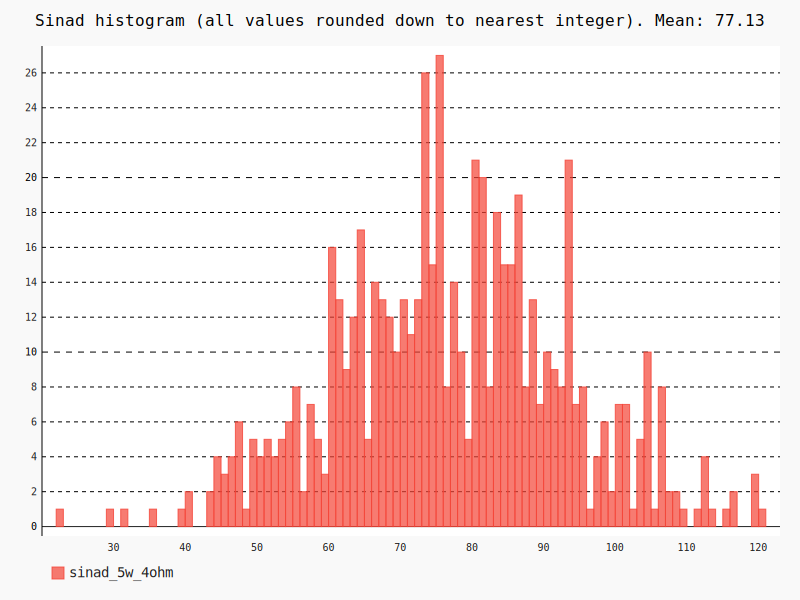

In [48]:
chart = pygal.Histogram()
chart.config.title = f"Sinad histogram (all values rounded down to nearest integer). Mean: {round(data.sinad_5w_4ohm.mean(), 2)}"
chart.config.legend_at_bottom = True
chart.add('sinad_5w_4ohm',pygal_data)
display(SVG(chart.render(disable_xml_declaration=True)))

# Export to svg
chart.render_to_file("./chart-exports/sinad-5watt-4ohm-histogram.svg")

### Price usd vs sinad scatter plot

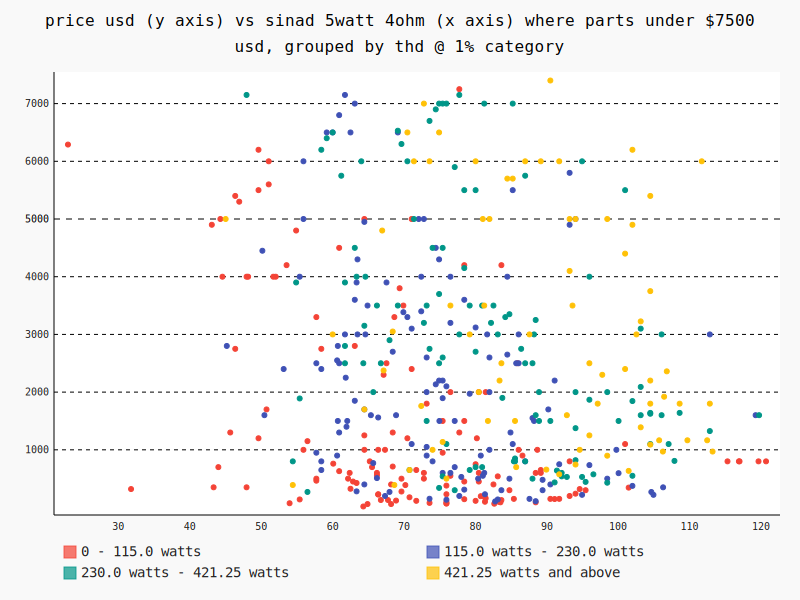

In [49]:
max_price_filter = 7500
first_quartile = data[(data.thd_quartile == "quartile 1") & (data.price_usd < max_price_filter)]
second_quartile = data[(data.thd_quartile == "quartile 2") & (data.price_usd < max_price_filter)]
third_quartile = data[(data.thd_quartile == "quartile 3") & (data.price_usd < max_price_filter)]
fourth_quartile = data[(data.thd_quartile == "quartile 4") & (data.price_usd < max_price_filter)]

chart = pygal.XY(stroke=False)
chart.config.title = f"price usd (y axis) vs sinad 5watt 4ohm (x axis) where parts under ${max_price_filter} usd,  grouped by thd @ 1% category"
chart.config.legend_at_bottom = True

# Add data
chart.add(quartile_dict["Q1"], list(zip(first_quartile.sinad_5w_4ohm, first_quartile.price_usd)))
chart.add(quartile_dict["Q2"], list(zip(second_quartile.sinad_5w_4ohm, second_quartile.price_usd)))
chart.add(quartile_dict["Q3"], list(zip(third_quartile.sinad_5w_4ohm, third_quartile.price_usd)))
chart.add(quartile_dict["Q4"], list(zip(fourth_quartile.sinad_5w_4ohm, fourth_quartile.price_usd)))


display(SVG(chart.render(disable_xml_declaration=True)))
# Export to svg
chart.render_to_file("./chart-exports/price-usd-vs-sinad-5watt-4ohm-scatterplot.svg")